# Лабораторная №2. Supervised

В этом лабораторной работе мы будем обрабатывать наш датасет, а также обучать модели с учителем на примере `Random Forest`, а также делать `Custom Random Forest`

- В конфигурации настраиваются:
  - путь к файлу
  - переименование столбцов для удобства понимания после one-hot encoding
  - Выбор данных (покупка в собственность/аренда)
  - Настройка квантилей для устранения выбросов
  
> В Excel-файле находится таблица для сравнения исходных данных и моделей предсказания (их результатов предсказания)

## Импорты

In [370]:
import warnings

# Отключаем все предупреждения
warnings.filterwarnings('ignore')

In [371]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union, List

In [372]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as adaptive_error_func
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

## Конфигурация

In [373]:
# config
file_path = "../../parser-GameTrue/Lab_1/resultCSV/Summarize.xlsx"
data_rename = {'Интернет и ТВ':'Сеть', 'Балкон или лоджия':'Балкон', 'Region':'Город'}
buy_or_rent = 'Купить'				# 'Купить' / 'Снять'
quantile_1 = 0.2
quantile_2 = 0.8
DEBUG = False
custom_value_debug = False
custom_data_debug = 'Excel' 		# 'Excel' / 'Manual'
scoring_error = 'neg_mean_absolute_error'
scoring_type = "MAE"


## Функции

In [374]:
def check_data(data : pd.DataFrame, debug : bool=DEBUG, debugPercent : int=45) -> None: 
    """
    Проверяет наличие пропусков в данных и выводит статистику.

    Параметры:
    - data (pd.DataFrame): Исходный DataFrame.
    - debug (bool): Если True, выводит дополнительную информацию о пропусках в каждом столбце.

    Возвращает:
    - None.
    """
    
    total_rows = data.shape[0]
    rows_with_all_data = data.dropna().shape[0]

    print(f"Количество строк с полными данными: {rows_with_all_data}")
    print(f"Количество строк с пропусками: {total_rows - rows_with_all_data}")

    if debug:
        print("\nКоличество пропусков в каждом столбце:")
        missing_values = data.isnull().sum()
        print(missing_values[missing_values > 0])

        print(f"\nПроцент пропущенных значений (>{debugPercent}%) в каждом столбце:")
        missing_percentage = data.isnull().mean() * 100
        print(missing_percentage[missing_percentage > debugPercent])


In [375]:
def print_missing(data : pd.DataFrame, column : str) -> None:
	"""
    Выводит строки с пропущенными значениями в указанном столбце.

    Параметры:
    - data (pd.DataFrame): Исходный DataFrame.
    - column (str): Название столбца для проверки на пропуски.

    Возвращает:
    - None.
    """
    
	print(f"Строки с пропусками в столбце '{column}':")
	print(data[data[column].isna()])

In [376]:
def pd_to_int(data : pd.DataFrame, target_columns : Union[str, List[str]], debug : bool=DEBUG) -> pd.DataFrame:
    """
    Преобразует указанные столбцы DataFrame в целочисленный тип, заменяя пропуски на 0.
    
    Аргументы:
		- **data**: pd.DataFrame — исходный DataFrame.
		- **target_columns**: Union[str, List[str]] — столбец или список столбцов для преобразования.
		- **debug**: bool — если True, выводит уникальные значения и тип данных каждого обработанного столбца.
    
    Возвращает:
    	- pd.DataFrame с преобразованными столбцами.
    """
	
	# Если target_columns строка, превращаем её в список из одного элемента
    if isinstance(target_columns, str):
        target_columns = [target_columns]

    # Проходим по каждому столбцу в списке target_columns
    for column in target_columns:
        # Преобразуем значения столбца к числовому типу
        data[column] = pd.to_numeric(data[column], errors='coerce')
        # Заполняем NaN значением 0 и преобразуем к целочисленному типу
        data[column] = data[column].fillna(0).astype(int)
        # Проверяем уникальные значения в текущем столбце
        if debug:
            unique_vals = data[column].unique()
            print(f"Unique values in column '{column}': {unique_vals[:10]}{'...' if len(unique_vals) > 10 else ''}")
            print(f"Data type of column '{column}': {data[column].dtype}")

    return data

In [377]:
def pd_type(data : pd.DataFrame, target_columns : Union[str, List[str]]) -> None:
	"""
    Выводит типы данных указанных столбцов.

    Параметры:
		- **data** (pd.DataFrame): Исходный DataFrame.
		- **target_columns** (Union[str, List[str]]): Столбец или список столбцов для проверки типа данных.

    Возвращает:
    	- None.
    """
	
	if isinstance(target_columns, str):
		target_columns = [target_columns]

    # Проходим по каждому столбцу в списке target_columns
	for column in target_columns:
		print(f"Data type of column '{column}': {data[column].dtype} \n")

In [378]:
def fill_missing_area_by_ratio(data : pd.DataFrame, target_column : str, base_column : str, group_column : str, studio_ratio=None, debug=DEBUG):
    """
    Заполняет пропуски в площади (target_column) на основе отношения к общей площади (base_column), сгруппированных по количеству комнат (group_column).
    
    Параметры:
		- **data** (pd.DataFrame): Исходный DataFrame.
		- **target_column** (str): Столбец для заполнения пропусков (например, "Площадь кухни").
		- **base_column** (str): Столбец для расчета коэффициента (например, "Общая площадь").
		- **group_column** (str): Столбец для группировки (например, "Количество комнат").
		- **studio_ratio** (float, optional): Фиксированный коэффициент для студий.
		- **debug** (bool): Если True, выводит средние коэффициенты по группам.

    Возвращает:
    	- **pd.DataFrame**: DataFrame с заполненными значениями в target_column.
    """
    # Рассчитаем коэффициент площади (target_column / base_column) по каждой группе
    data['Коэффициент'] = data[target_column] / data[base_column]
    
    # Рассчитываем средний коэффициент для каждой группы по количеству комнат, исключая строки с NaN
    mean_ratio_by_rooms = (
		data.groupby(group_column)
		.apply(lambda x: (x[target_column] / x[base_column]).mean())
	)
    
    if debug:
         print(mean_ratio_by_rooms)
    
    # Функция для заполнения пропусков
    def fill_area(row):
        if pd.isna(row[target_column]):
            room_count = row[group_column]
            if room_count == 0 and studio_ratio:  # Если студия (0 комнат) и указан коэффициент
                return studio_ratio * row[base_column]
            elif room_count in mean_ratio_by_rooms.index:  # Если есть коэффициент для данного количества комнат
                return mean_ratio_by_rooms[room_count] * row[base_column]
        return row[target_column]
    
    # Применяем функцию к строкам с пропусками
    data[target_column] = data.apply(fill_area, axis=1)
    
    # Округляем результат до одного знака после запятой
    data[target_column] = data[target_column].round(1)
    
    # Удаляем временный столбец с коэффициентом
    data.drop(columns=['Коэффициент'], inplace=True)
    
    return data

In [379]:
def fix_year(year : Union[float, int]) -> int:
    """
    Приводит год к формату полной даты, добавляя 1900 или 2000.

    Параметры:
    	- **year** (Union[float, int]): Год для корректировки.

    Возвращает:
    	- **int**: Исправленный год.
    
    Например:
		- 99 -> 1999
		- 87 -> 1987
		- 04 -> 2004
    """


    if year > 24 and year < 1000:
        return year + 1900
    elif year <= 24:
        return year + 2000
    else:
        return year

In [380]:
def one_hot_encode_multilabel(data : pd.DataFrame, target_columns : Union[str, List[str]], prefix:bool=False) -> pd.DataFrame:
    """
    Применяет One-Hot Encoding к мульти-меточным столбцам.

    Параметры:
    - data (pd.DataFrame): Исходный DataFrame.
    - target_columns (Union[str, List[str]]): Столбец или список столбцов для кодирования.
    - prefix (bool): Если True, добавляет префикс названия столбца к новым столбцам.

    Возвращает:
    - pd.DataFrame: Обновленный DataFrame с закодированными значениями.
    """
    
    if isinstance(target_columns, str):
        target_columns = [target_columns]

    for column in target_columns:
        dummies = data[column].str.get_dummies(sep=', ')
        if prefix:
            dummies = dummies.add_prefix(f"{column}: ")
        data = pd.concat([data, dummies], axis=1).drop(columns=[column])

    return data

In [381]:
def extract_category_column(data: pd.DataFrame, prefixes: Union[str, List[str]]) -> pd.DataFrame:
    """
    Anti One-Hot Encoding function
    
    Извлекает значения с 1 из столбцов, соответствующих указанным префиксам, 
    и объединяет их в строку через запятую для каждого префикса.

    Параметры:
    - data: pd.DataFrame — исходный DataFrame.
    - prefixes: list — список префиксов столбцов для извлечения значений.

    Возвращает:
    - pd.DataFrame с объединенными значениями для каждого префикса.
    """
    
    # Если передан один префикс в виде строки, преобразуем его в список для унификации обработки
    if isinstance(prefixes, str):
        prefixes = [prefixes]

    result_df = pd.DataFrame()

    for prefix in prefixes:
        # Фильтруем только столбцы, начинающиеся на текущий префикс
        category_columns = [col for col in data.columns if col.startswith(prefix)]

        if not category_columns:
            raise ValueError(f"В DataFrame нет столбцов, начинающихся с '{prefix}'")

        # Объединяем значения для каждой строки
        combined_column = data[category_columns].apply(lambda row: ', '.join(
            col.split(": ")[-1] for col, val in row.items() if val == 1
        ), axis=1)

        # Добавляем новый столбец в итоговый DataFrame
        new_column_name = prefix.rstrip(":")  # Удаляем двоеточие в конце, если есть
        result_df[new_column_name] = combined_column

    return result_df


## Обработка данных

### Подключение файла

In [382]:

# Load the dataset
data = pd.read_excel(file_path, sheet_name="Summarize")

# Show the first few rows of 	the dataset to understand its structure
data.head()


,Вид сделки,Общая площадь,URL,Грузовой лифт,Ремонт,Дополнительно,Тёплый пол,В доме,Техника,Тип дома,...,Тип комнат,Комфорт,Этажей в доме,Площадь кухни,Количество комнат,Парковка,Способ продажи,Жилая площадь,Запланирован снос,Отделка
0,NaN,54.9,https://www.avito.ru/sankt-peterburg/kvartiry/...,1.0,дизайнерский,NaN,NaN,NaN,"кондиционер, холодильник, плита, микроволновка...",панельный,...,изолированные,NaN,12.0,9.6,2.0,NaN,NaN,31.0,NaN,NaN
1,возможна ипотека,55.6,https://www.avito.ru/sankt-peterburg/kvartiry/...,1.0,требует ремонта,NaN,NaN,NaN,NaN,монолитно-кирпичный,...,изолированные,NaN,13.0,17.4,2.0,подземная,свободная,27.3,NaN,NaN
2,возможна ипотека,47.5,https://www.avito.ru/sankt-peterburg/kvartiry/...,1.0,дизайнерский,"гардеробная, панорамные окна",есть,консьерж,"холодильник, стиральная машина, посудомоечная ...",монолитный,...,NaN,NaN,7.0,28.0,1.0,подземная,свободная,NaN,NaN,NaN
3,возможна ипотека,21.8,https://www.avito.ru/sankt-peterburg/kvartiry/...,1.0,дизайнерский,NaN,NaN,NaN,"холодильник, стиральная машина",монолитно-кирпичный,...,NaN,NaN,22.0,NaN,студия,"наземная многоуровневая, открытая во дворе",свободная,NaN,NaN,NaN
4,возможна ипотека,32.4,https://www.avito.ru/sankt-peterburg/kvartiry/...,NaN,дизайнерский,NaN,NaN,"мусоропровод, газ","холодильник, стиральная машина",панельный,...,NaN,NaN,9.0,6.6,1.0,открытая во дворе,свободная,18.6,NaN,NaN


### Обработка данных

#### Drop
Дропаем ненужные(тяжело обрабатывамые/не имеющие возможность подставить подходящее для дальнейшего обучения/мало квартир содержат данные) колонки

In [383]:
check_data(data, True)

Количество строк с полными данными: 0
Количество строк с пропусками: 11063

Количество пропусков в каждом столбце:
Вид сделки                     9475
Грузовой лифт                  4718
Ремонт                         1189
Дополнительно                  9802
Тёплый пол                    10855
В доме                         9640
Техника                        2307
Тип дома                       1175
Двор                           9098
Мебель                         3151
Интернет и ТВ                  4894
Пассажирский лифт              3623
Залог                          9891
Окна                           8969
Год постройки                  4931
Кровати                        9949
Балкон или лоджия              4085
Высота потолков                9659
Возможна помесячная аренда    10145
Санузел                        2151
Тип комнат                     7188
Комфорт                        9927
Этажей в доме                    44
Площадь кухни                  3143
Парковка             

In [384]:
drop_list = ["Адрес", "PhotoLinks", "URL", "Кровати", 'Вид сделки', "Дополнительно", "В доме",
			  "Двор", "Окна", "Высота потолков", "Способ продажи", "Запланирован снос", "Отделка",
			    "Тип комнат", "Возможна помесячная аренда", "Комфорт"]

In [385]:
data = data.drop(columns=drop_list)


#### Обработка пропуков

##### Обработка значений по лифту

In [386]:
# Если пропуск в "Грузовой лифт" или "Грузовой лифт" == "нет", то 0 
data.loc[(data['Грузовой лифт'] == 'нет') | (data['Грузовой лифт'].isna()), 'Грузовой лифт'] = 0

# Если пропуск в "Пассажирский лифт" и "Этажей в доме" <= 5, то 0
data.loc[data['Пассажирский лифт'].isna() & (data['Этажей в доме'] <= 5), 'Пассажирский лифт'] = 0

# Если пропуск в "Пассажирский лифт" и "Этажей в доме" > 5, то 1
data.loc[data['Пассажирский лифт'].isna() & (data['Этажей в доме'] > 5), 'Пассажирский лифт'] = 1


##### Обработка простых пропусков

In [387]:
# Заменим значения "студия" на 0
data['Количество комнат'].replace('студия', 0, inplace=True)

# Заменим значения "студия" на 0
data['Парковка'].replace('нет', np.nan, inplace=True)

# Затем заполним пропущенные значения (NaN) нулями
data['Залог'].fillna(0, inplace=True)

# Сначала заменим значения "0" на среднее значение года
data['Год постройки'].replace(0, 1980, inplace=True)

# Затем заполним пропущенные значения (NaN) на среднее значение года
data['Год постройки'].fillna(1980, inplace=True)

# # Затем заполним пропущенные значения (NaN) Теплого пола
# data['Тёплый пол'].fillna("нет", inplace=True)

# # Затем заполним пропущенные значения (NaN) на парковку во дворе
# data['Парковка'].fillna("открытая во дворе", inplace=True)

# # Затем заполним пропущенные значения (NaN) на "нет"
# data['Балкон или лоджия'].fillna("Нет", inplace=True)

# # Затем заполним пропущенные значения (NaN) в ремонте
# data['Ремонт'].fillna("косметический", inplace=True)

# # Затем заполним пропущенные значения (NaN) Интернета и ТВ
# data['Интернет и ТВ'].fillna("Не указано", inplace=True)

# # Затем заполним пропущенные значения (NaN) Интернета и ТВ
# data['Техника'].fillna("Не указано", inplace=True)

# # Затем заполним пропущенные значения (NaN) для Санузла
# data['Санузел'].fillna("совмещенный", inplace=True)

In [388]:
# Применяем функцию ко всему столбцу с годами постройки
data['Год постройки'] = data['Год постройки'].apply(fix_year)

# # Проверяем результат
# print(data['Год постройки'].unique())

In [389]:
# Рассчитываем средний год постройки для каждого города
# mean_year_by_city = data_rent2.groupby('Region')['Год постройки'].transform('mean').unique()

# mean_year_by_city

##### Обрабатываем пропуски разделения площади (Жилая/Кухня)

In [390]:
# Проверим наличие пропусков в "Общая площадь"
print(data['Общая площадь'].isna().sum())



0


In [391]:
# Сначала сохраняем строки с пропусками в "Жилая площадь" до изменений
before_changes = data[data['Жилая площадь'].isna()].copy()

In [392]:
# Применение функции для "Площадь кухни" с коэффициентом для студий
data = fill_missing_area_by_ratio(data, target_column='Площадь кухни', base_column='Общая площадь', 
                                  group_column='Количество комнат', studio_ratio=0.3129496, debug=True)

# Применение функции для "Жилая площадь" (если коэффициент для студий не требуется, можно не указывать)
data = fill_missing_area_by_ratio(data, target_column='Жилая площадь', base_column='Общая площадь', 
                                  group_column='Количество комнат', debug=True)

Количество комнат
0           NaN
1.0    0.257698
2.0    0.181022
3.0    0.151457
4.0    0.120315
5.0    0.131549
6.0    0.098039
9.0    0.176471
dtype: float64


Количество комнат
0      0.758463
1.0    0.531991
2.0    0.629021
3.0    0.664857
4.0    0.695990
5.0    0.634700
6.0         NaN
9.0    0.784314
dtype: float64


In [393]:
# Сохраняем строки после изменений
after_changes = data.loc[before_changes.index]

# Сравниваем до и после
comparison = pd.concat([before_changes['Жилая площадь'], after_changes['Жилая площадь']], axis=1)
comparison.columns = ['Before', 'After']

# Выводим результат
print(comparison)

       Before  After
2         NaN   25.3
3         NaN   16.5
10        NaN   68.2
11        NaN   17.6
15        NaN   36.7
...       ...    ...
11050     NaN   22.9
11051     NaN   22.0
11056     NaN   44.0
11058     NaN   32.7
11060     NaN   29.6

[4379 rows x 2 columns]


In [394]:
# # Сначала сохраняем строки с пропусками в "Площадь кухни" до изменений
# before_changes = data[data['Площадь кухни'].isna()].copy()

# # Рассчитаем среднее соотношение "Площадь кухни / Общая площадь" для каждого количества комнат
# mean_ratio_by_rooms = (
#     data.groupby('Количество комнат')
#     .apply(lambda x: (x['Жилая площадь'] / x['Общая площадь']).mean())
# )



# mean_ratio_by_rooms

In [395]:
# print_missing(data, "Площадь кухни")

In [396]:
# # Определим фиксированный коэффициент для студий
# studio_ratio = 0.3129496

# # Функция для заполнения пропусков
# def fill_kitchen_area(row):
#     if pd.isna(row['Площадь кухни']):
#         room_count = row['Количество комнат']
#         if room_count == 0:  # Если студия (0 комнат)
#             return studio_ratio * row['Общая площадь']
#         elif room_count in mean_ratio_by_rooms.index:  # Если есть коэффициент для данного количества комнат
#             return mean_ratio_by_rooms[room_count] * row['Общая площадь']
#     return row['Площадь кухни']

# # Применяем функцию к строкам с пропусками
# data['Площадь кухни'] = data.apply(fill_kitchen_area, axis=1)

# # Округляем значения в столбце "Площадь кухни" до одного знака после запятой
# data['Площадь кухни'] = data['Площадь кухни'].round(1)

# # Проверим результат
# print(data.loc[data['Площадь кухни'].isna()])


#### Преобразование данных
После иземений и их проверки меняем тип столбцов на целочисленный там, где необходимо

In [397]:
intDataList = ["Цена", "Количество комнат", "Пассажирский лифт", "Грузовой лифт", "Этаж", "Год постройки", "Этажей в доме", "Залог"]
data = pd_to_int(data, intDataList)

In [398]:
data.head()

,Общая площадь,Грузовой лифт,Ремонт,Тёплый пол,Техника,Тип дома,Мебель,Интернет и ТВ,Пассажирский лифт,Цена,...,Region,Купить,Год постройки,Балкон или лоджия,Санузел,Этажей в доме,Площадь кухни,Количество комнат,Парковка,Жилая площадь
0,54.9,1,дизайнерский,NaN,"кондиционер, холодильник, плита, микроволновка...",панельный,"кухня, хранение одежды, спальные места",Wi-Fi,1,77000,...,sankt-peterburg,Снять,1989,лоджия,раздельный,12,9.6,2,NaN,31.0
1,55.6,1,требует ремонта,NaN,NaN,монолитно-кирпичный,NaN,NaN,1,12000000,...,sankt-peterburg,Купить,2022,"балкон, лоджия",раздельный,13,17.4,2,подземная,27.3
2,47.5,1,дизайнерский,есть,"холодильник, стиральная машина, посудомоечная ...",монолитный,"кухня, хранение одежды, спальные места",NaN,1,17700000,...,sankt-peterburg,Купить,2021,балкон,совмещенный,7,28.0,1,подземная,25.3
3,21.8,1,дизайнерский,NaN,"холодильник, стиральная машина",монолитно-кирпичный,кухня,NaN,1,5500000,...,sankt-peterburg,Купить,2019,лоджия,совмещенный,22,6.8,0,"наземная многоуровневая, открытая во дворе",16.5
4,32.4,0,дизайнерский,NaN,"холодильник, стиральная машина",панельный,"кухня, хранение одежды, спальные места",NaN,1,7190000,...,sankt-peterburg,Купить,1971,NaN,раздельный,9,6.6,1,открытая во дворе,18.6


#### Изменение названия столбцов
Необходимо для удобства после применения one-hot encoding

In [399]:
data.rename(columns=data_rename, inplace=True)

#### One-Hot Encoding

In [400]:
# data['Парковка'].unique()

In [401]:
numerical_columns = data.select_dtypes(include=['number']).columns
categorial_variables = data.select_dtypes(include=['object']).columns
categorial_variables

Index(['Ремонт', 'Тёплый пол', 'Техника', 'Тип дома', 'Мебель', 'Сеть',
       'Город', 'Купить', 'Балкон', 'Санузел', 'Парковка'],
      dtype='object')

In [402]:
onehotVariables = categorial_variables.drop('Купить')
data2 = one_hot_encode_multilabel(data, onehotVariables, True)
data2.head()

,Общая площадь,Грузовой лифт,Пассажирский лифт,Цена,Залог,Этаж,Купить,Год постройки,Этажей в доме,Площадь кухни,...,Балкон: лоджия,Санузел: раздельный,Санузел: совмещенный,Парковка: бесплатно для гостей,Парковка: в здании,Парковка: за шлагбаумом во дворе,Парковка: на улице,Парковка: наземная многоуровневая,Парковка: открытая во дворе,Парковка: подземная
0,54.9,1,1,77000,0,7,Снять,1989,12,9.6,...,1,1,0,0,0,0,0,0,0,0
1,55.6,1,1,12000000,0,7,Купить,2022,13,17.4,...,1,1,0,0,0,0,0,0,0,1
2,47.5,1,1,17700000,0,5,Купить,2021,7,28.0,...,0,0,1,0,0,0,0,0,0,1
3,21.8,1,1,5500000,0,10,Купить,2019,22,6.8,...,1,0,1,0,0,0,0,1,1,0
4,32.4,0,1,7190000,0,3,Купить,1971,9,6.6,...,0,1,0,0,0,0,0,0,1,0


In [403]:
data = data2

### Разделение данных

In [404]:
# Фильтруем строки, где значение в столбце "Купить" равно "Купить"
newData = data[data['Купить'] == buy_or_rent].drop(columns=['Купить'], inplace=False)

# Проверяем размеры новых таблиц
print(f"Количество строк, где 'Купить': {data[data['Купить'] == 'Купить'].shape[0]}")
print(f"Количество строк, где 'Снять': {data[data['Купить'] == 'Снять'].shape[0]}")

# Удаляем все строки с пропусками
newData = newData.dropna(how='any')


Количество строк, где 'Купить': 2702
Количество строк, где 'Снять': 8361


In [405]:
check_data(newData, debug=True)


Количество строк с полными данными: 2700
Количество строк с пропусками: 0

Количество пропусков в каждом столбце:
Series([], dtype: int64)

Процент пропущенных значений (>45%) в каждом столбце:
Series([], dtype: float64)


In [406]:

# Checking for missing values in the dataset
missing_data = newData.isnull().sum()

pd_type(newData, numerical_columns)

Data type of column 'Общая площадь': float64 

Data type of column 'Грузовой лифт': int32 

Data type of column 'Пассажирский лифт': int32 

Data type of column 'Цена': int32 

Data type of column 'Залог': int32 

Data type of column 'Этаж': int32 

Data type of column 'Год постройки': int32 

Data type of column 'Этажей в доме': int32 

Data type of column 'Площадь кухни': float64 

Data type of column 'Количество комнат': int32 

Data type of column 'Жилая площадь': float64 



### Обработка отсутствующих значений и выбросов

In [407]:


# for col in numerical_columns:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(newData[col], kde=True)
#     plt.title(f'Распределение для {col}')
#     plt.show()


In [408]:
# Вывод статистики до удаления выбросов
print("Статистика до удаления выбросов:")
print(newData[numerical_columns].describe())

# Применение удаления выбросов снова на копии, чтобы сравнить статистику
data_filtered = newData.copy()
for col in numerical_columns:
    Q1 = data_filtered[col].quantile(quantile_1)
    Q3 = data_filtered[col].quantile(quantile_2)
    IQR = Q3 - Q1
    data_filtered = data_filtered[~((data_filtered[col] < (Q1 - 1.5 * IQR)) | (data_filtered[col] > (Q3 + 1.5 * IQR)))]

print("Статистика после удаления выбросов:")
print(data_filtered[numerical_columns].describe())


Статистика до удаления выбросов:
       Общая площадь  Грузовой лифт  Пассажирский лифт          Цена   Залог  \
count    2700.000000    2700.000000        2700.000000  2.700000e+03  2700.0   
mean       45.593037       0.314074           0.714074  6.450398e+06     0.0   
std        18.966978       0.552426           0.653677  5.882516e+06     0.0   
min        10.000000       0.000000           0.000000  5.500000e+05     0.0   
25%        33.200000       0.000000           0.000000  3.400000e+06     0.0   
50%        43.100000       0.000000           1.000000  4.700000e+06     0.0   
75%        55.000000       1.000000           1.000000  7.000000e+06     0.0   
max       210.500000       4.000000           4.000000  8.900000e+07     0.0   

              Этаж  Год постройки  Этажей в доме  Площадь кухни  \
count  2700.000000    2700.000000    2700.000000    2700.000000   
mean      5.323704    1987.737037       9.763333       8.774185   
std       4.246441      20.752402       6.339

### Построение графиков распределения

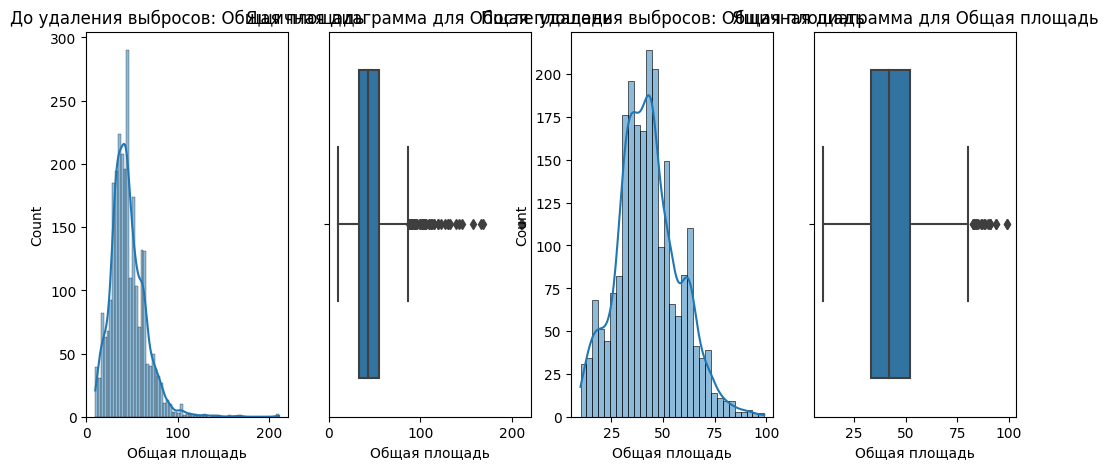

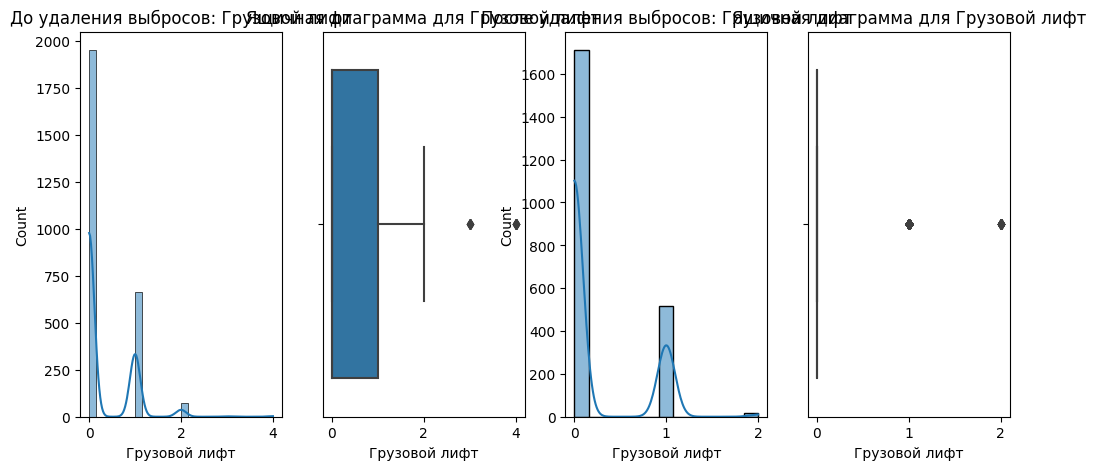

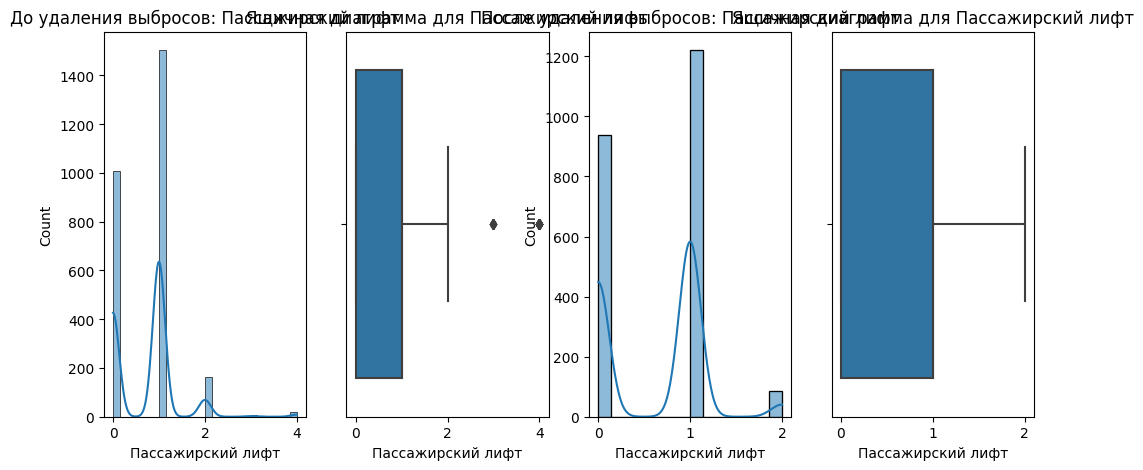

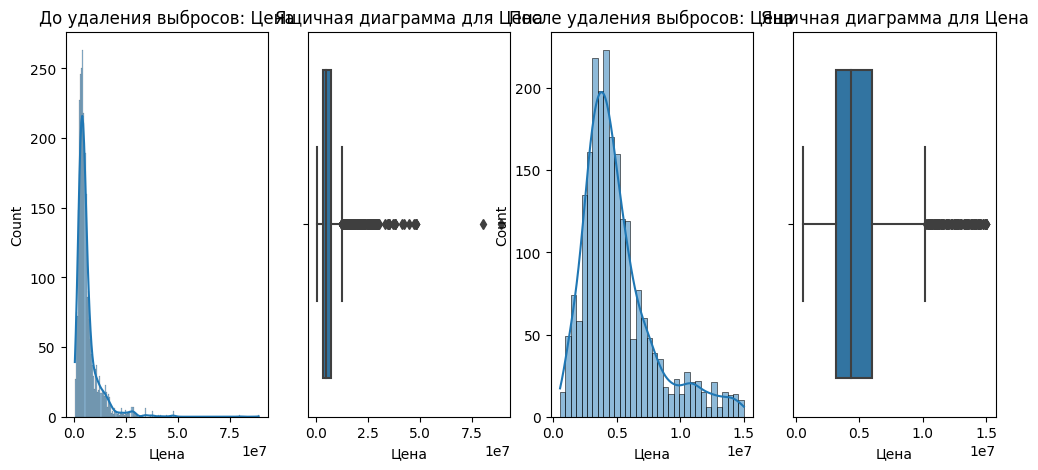

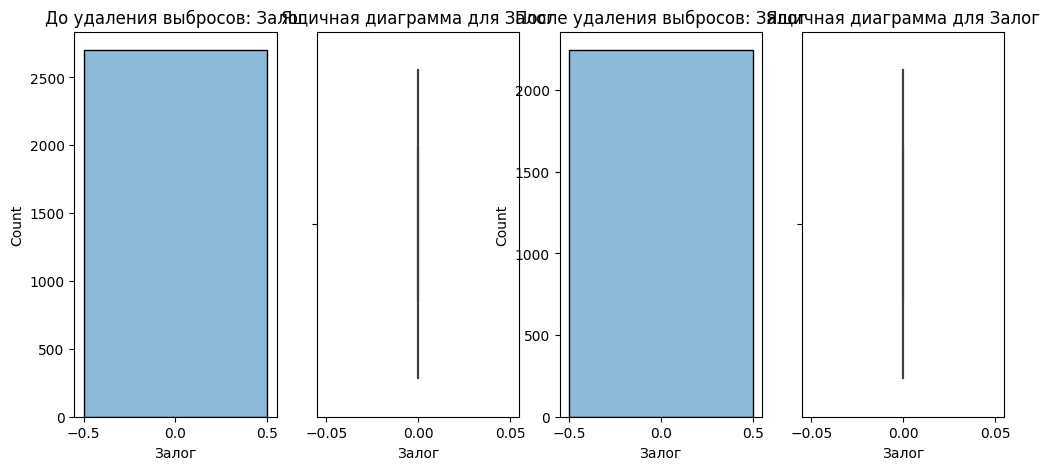

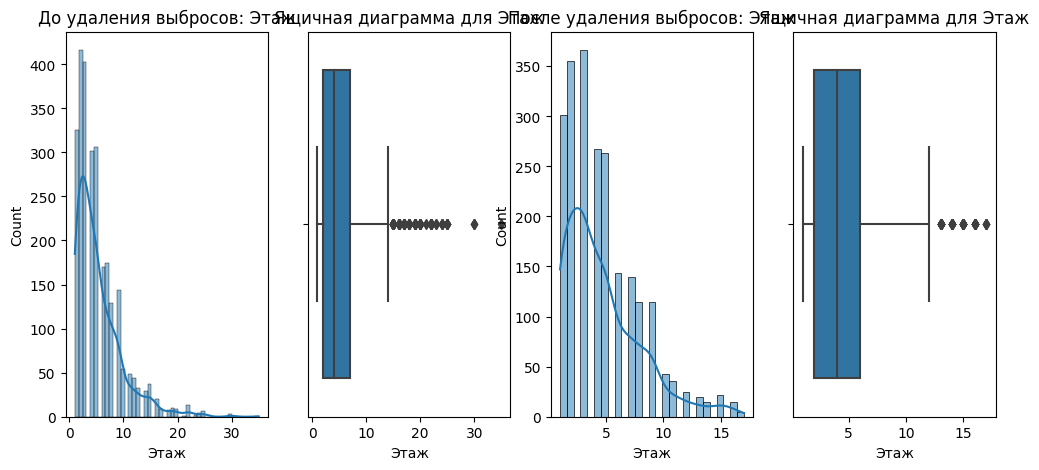

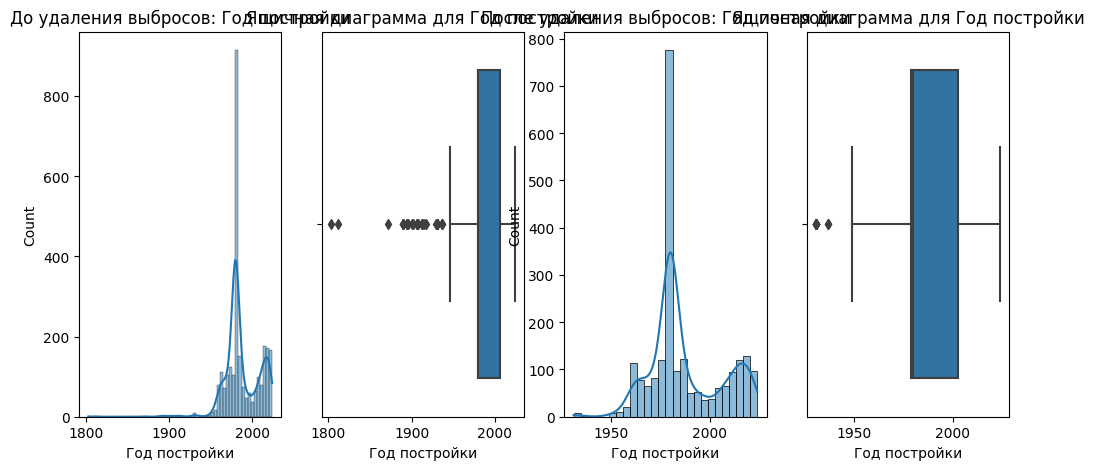

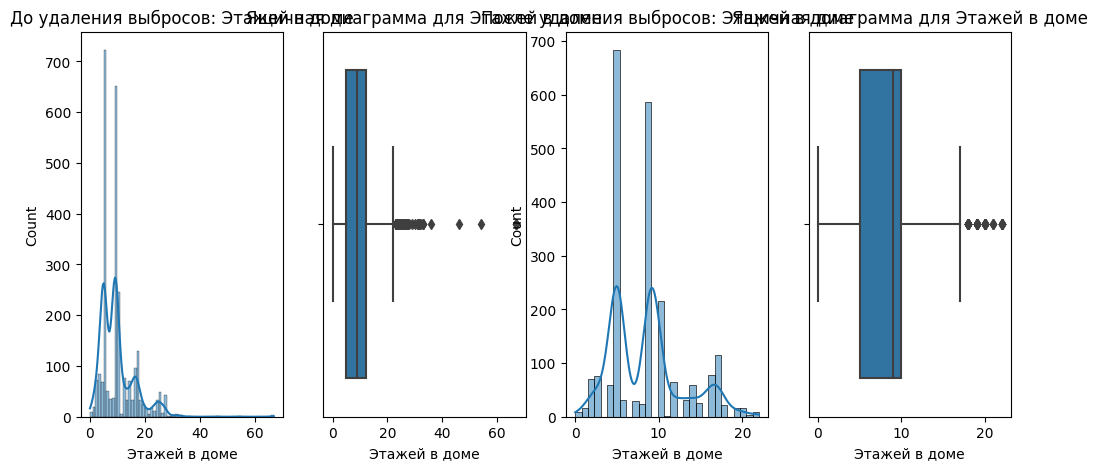

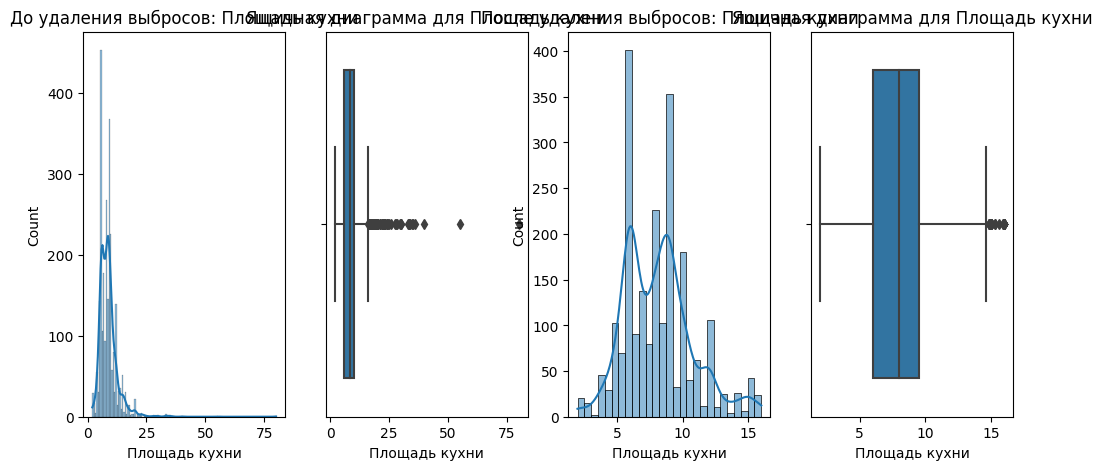

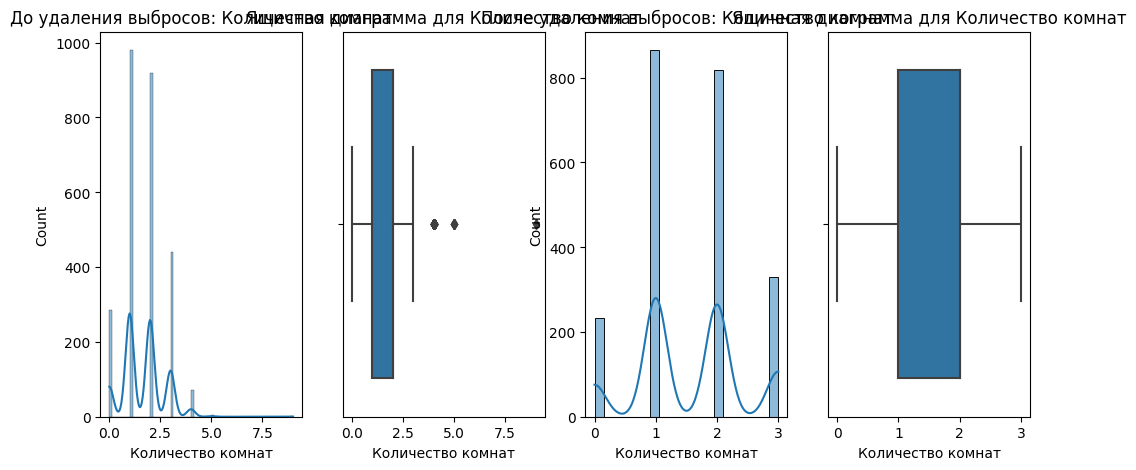

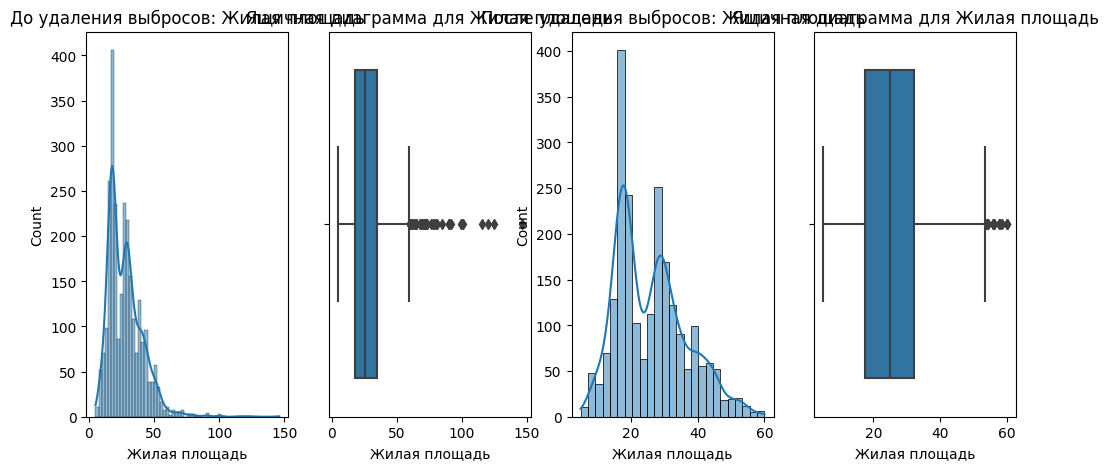

In [409]:
import seaborn as sns
import matplotlib.pyplot as plt

# Пример для одной переменной (можно применить в цикле для всех числовых переменных)
for col in numerical_columns:
    plt.figure(figsize=(12, 5))

    # Гистограмма до удаления выбросов
    plt.subplot(1, 4, 1)
    sns.histplot(newData[col], kde=True)
    plt.title(f'До удаления выбросов: {col}')
    
	
    
    # Ящичная диаграмма для поиска выбросов
    plt.subplot(1, 4, 2)
    sns.boxplot(x=newData[col])
    plt.title(f'Ящичная диаграмма для {col}')

    # Гистограмма после удаления выбросов
    plt.subplot(1, 4, 3)
    sns.histplot(data_filtered[col], kde=True)
    plt.title(f'После удаления выбросов: {col}')
    
    # Ящичная диаграмма для поиска выбросов
    plt.subplot(1, 4, 4)
    sns.boxplot(x=data_filtered[col])
    plt.title(f'Ящичная диаграмма для {col}')

    plt.show()


**Диаграммы выыбросов**

Как можно видеть после принятия изменений, количество выбросов уменьшилось, ящичная диаграмма показывает уемньшение точечных данных, которые сбивали бы модель. 


**Диаграммы распределения**

На основных диаграммах распределения можно видеть, как ушли данные мизерного количества (*исключения*), теперь предсказать цену квартиры проще, а также видно, что графики стали более читабельны, а также стали лучше отображать зависимость и пропали столбы единичных данных, которые только растягивали графики, из-за которых может показаться квадратичная зависимость в некоторых случаях, вместо линейной. 


**Яркие изменения после обработки данных**

Особенно видны изменения на диаграммах распределения столбцов `Цена`, `(Общая/жилая/кухонная) площадь`, `год постройки`
Пропали данные, '*ужимающшие*' основные данные
Помимо, столбцы `Этажей в доме`, `количество комнат` получили повышение плотности данных, были исключены отдельные объявления, которые и вовсе могли быть неправильно заполнены пользователями.

Остальные данные получили более точные показатели по признакам



**Конфигурация**

Также реализована конфигурационная структура отделения данных(*обработки выбросов*) через конфигурационный файл, так что можно с легкостью контролировать баланс выбросов и данных для дальнейшего обучения. 

### Принятие изменений

In [410]:
newData = data_filtered

In [411]:
# for col in numerical_columns:
#     Q1 = newData[col].quantile(0.25)
#     Q3 = newData[col].quantile(0.75)
#     IQR = Q3 - Q1
#     newData = newData[~((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR)))]


<AxesSubplot: >

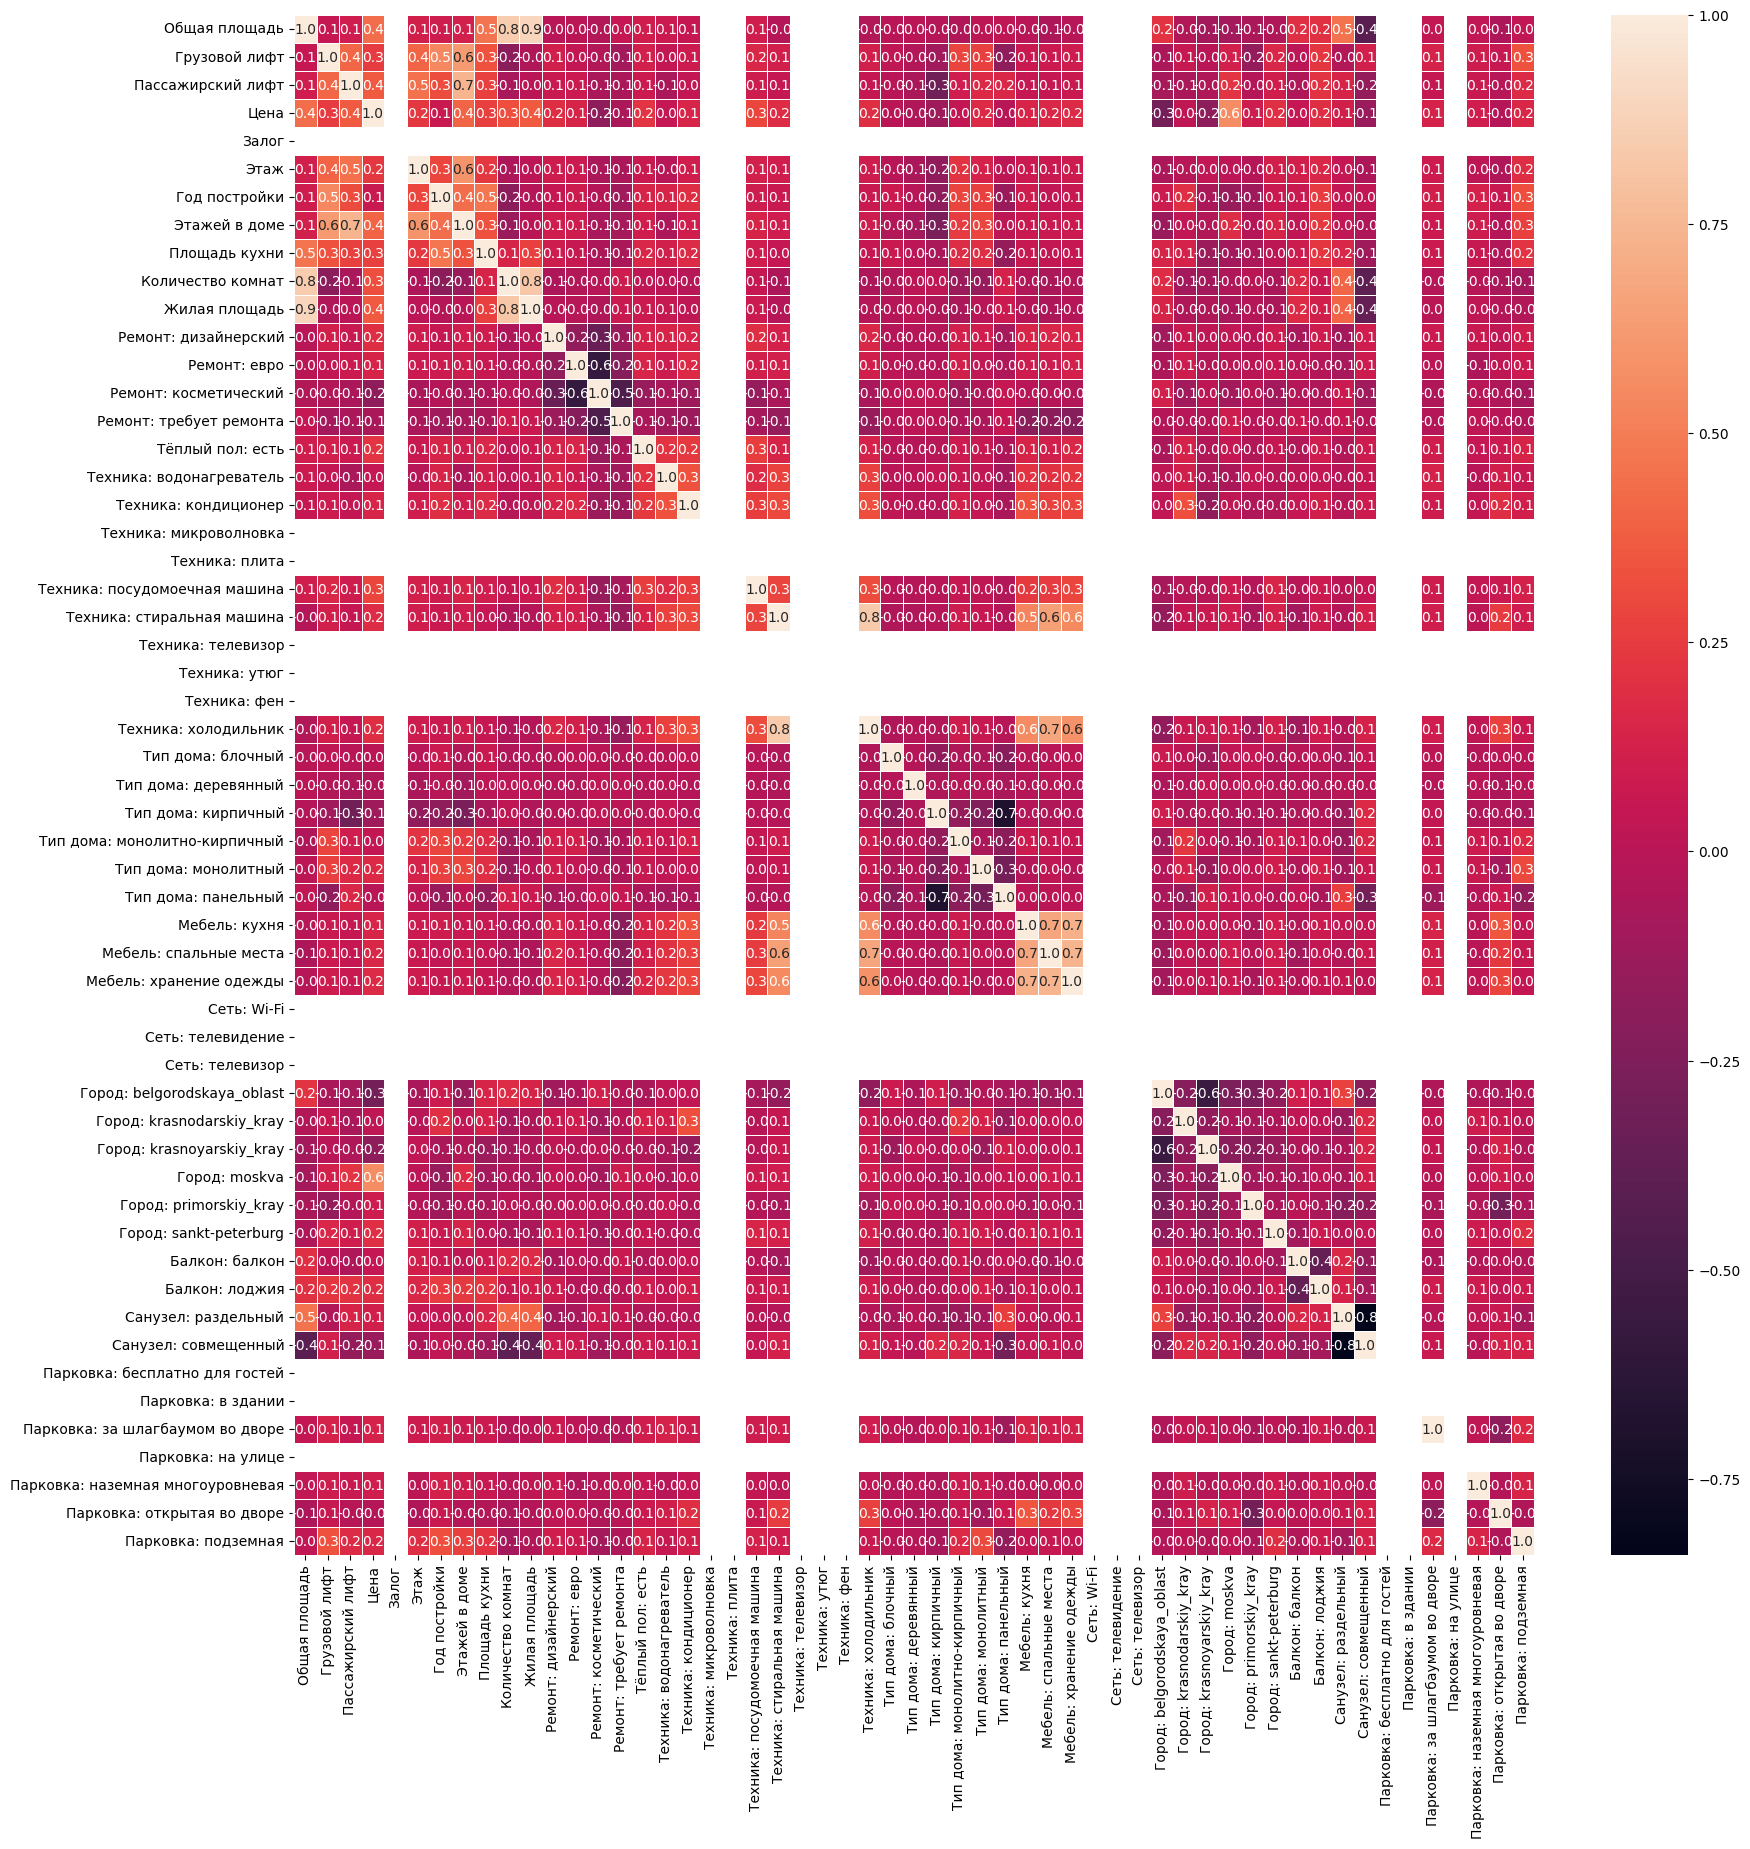

In [412]:
cor_mat=newData.corr()
fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(cor_mat,annot=True,linewidths=0.5,fmt="0.1f")

## Основная логика программы

### Построение baseline-решения
   - Создадим простую базовую модель, чтобы сравнить результаты с нашей будущей моделью. Например, это может быть модель, которая предсказывает медианное значение целевой переменной.
   - В нашем случае будем предсказывать цену, используя медианное значение на тренировочной выборке и сравним с эталоном.

In [413]:
def baseline_predict(y_train, y_val):
    # Пример простого правила
    return [y_train.median()] * len(y_val)

In [414]:
X = newData.drop(columns=['Цена'])  # Целевая переменная 'Цена'
y = newData['Цена']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Базовая модель на основе медианного значения
baseline_prediction = baseline_predict(y_train, y_val)

baseline_mse = adaptive_error_func(y_val, baseline_prediction)
print("MAE для baseline-модели:", baseline_mse)

MAE для baseline-модели: 2058590.5044510385


### Выбор и реализация модели
   - Для начала обучим **Random Forest** и оценим его качество.

In [415]:
# Инициализируем модель случайного леса
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

# Предсказания и оценка на валидационной выборке
val_predictions = model_rf.predict(X_val)
val_mse = adaptive_error_func(y_val, val_predictions)
print(f"{scoring_type} для случайного леса на валидационной выборке:", val_mse)


MAE для случайного леса на валидационной выборке: 569962.5705934718


### 6. Перебор гиперпараметров и оптимизация
Используем `GridSearchCV` для настройки гиперпараметров модели случайного леса. Среди важных гиперпараметров для настройки в случайном лесе:
 - `n_estimators` – количество деревьев в лесу.
 - `max_depth` – максимальная глубина деревьев.
 - `min_samples_split` и `min_samples_leaf` – минимальное количество образцов для разделения узла и для листа соответственно.

In [416]:


# Задаем сетку гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, scoring=scoring_error
)
grid_search_rf.fit(X_train, y_train)

# Лучшие параметры и оценка
# Лучшие параметры, подобранные по кросс-валидации
best_params = grid_search_rf.best_params_
print("Лучшие параметры:", best_params)
best_model_rf = grid_search_rf.best_estimator_
best_val_predictions = best_model_rf.predict(X_val)
best_val_mse = adaptive_error_func(y_val, best_val_predictions)
print("MAE для случайного леса с оптимальными гиперпараметрами на валидационной выборке:", best_val_mse)


Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE для случайного леса с оптимальными гиперпараметрами на валидационной выборке: 565498.5544510386


### 7. Оценка качества и проверка модели
   - Разделяем данные на **тренировочную, валидационную и тестовую выборки** и рассчитываем метрики для каждой выборки. Также построим график ошибок на каждой эпохе обучения.
   - Добавим проверку на тестовой выборке и визуализируем ошибки модели.

MAE для случайного леса на тестовой выборке: 635568.8452522256
MAE на тестовой выборке: 597316.0115727003


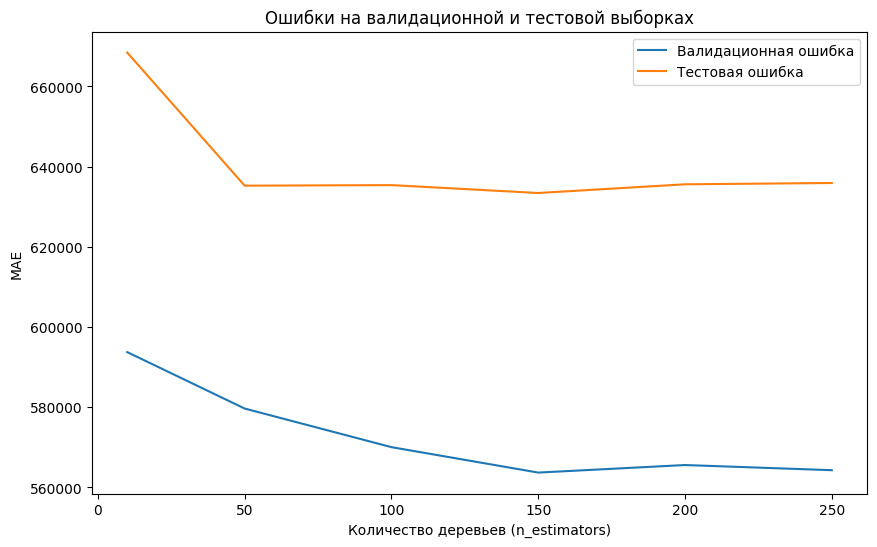

In [417]:
# Предсказания на тестовой выборке
test_predictions = best_model_rf.predict(X_test)
test_mse = adaptive_error_func(y_test, test_predictions)
print(f"{scoring_type} для случайного леса на тестовой выборке:", test_mse)


# Объединяем тренировочную и валидационную выборки
X_train_val_combined = pd.concat([X_train, X_val])
y_train_val_combined = pd.concat([y_train, y_val])

# Обучаем финальную модель
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train_val_combined, y_train_val_combined)

# Проверка на тестовой выборке с валидацией
test_val_predictions = final_model.predict(X_test)
test_val_mse = adaptive_error_func(y_test, test_val_predictions)
print(f"{scoring_type} на тестовой выборке:", test_val_mse)

# Оптимизация количества деревьев
estimators_range = [10, 50, 100, 150, 200, 250]
val_mses = []
test_mses = []

for n_estimators in estimators_range:
    temp_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    temp_model.fit(X_train, y_train)
    val_mses.append(adaptive_error_func(y_val, temp_model.predict(X_val)))
    test_mses.append(adaptive_error_func(y_test, temp_model.predict(X_test)))


# График метрик для валидационной и тестовой выборок по количеству деревьев
plt.figure(figsize=(10, 6))
plt.plot(estimators_range, val_mses, label="Валидационная ошибка")
plt.plot(estimators_range, test_mses, label="Тестовая ошибка")
plt.xlabel("Количество деревьев (n_estimators)")
plt.ylabel(f"{scoring_type}")
plt.title("Ошибки на валидационной и тестовой выборках")
plt.legend()
plt.show()


### 8. Реализация модели вручную
   - Реализуем упрощённую версию случайного леса самостоятельно, добавив два гиперпараметра: `количество деревьев` и `глубину дерева`. Затем обучим модель и сравним результаты с моделью из sklearn.

#### Реализация

In [418]:
class CustomRandomForest:
    def __init__(self, n_estimators=100, max_depth=None, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        
    # Метод для получения параметров модели (необходим для совместимости с GridSearchCV)
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'random_state': self.random_state
        }

    # Метод для установки параметров модели (необходим для совместимости с GridSearchCV)
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    def fit(self, X, y):
        np.random.seed(self.random_state)
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            # Создаем и обучаем отдельное дерево
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Собираем предсказания всех деревьев
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Среднее значение предсказаний деревьев
        return np.mean(tree_preds, axis=0)

# Обучение и проверка кастомного случайного леса
custom_rf = CustomRandomForest()
custom_rf.fit(X_train.values, y_train.values)
custom_rf_predictions = custom_rf.predict(X_val.values)
val_custom_mse = adaptive_error_func(y_val, custom_rf_predictions)
print(f"{scoring_type} для кастомного случайного леса на валидационной выборке:", val_custom_mse)


MAE для кастомного случайного леса на валидационной выборке: 567177.9749258161


#### Подбор гиперпараметров

In [419]:
# Задаем сетку гиперпараметров для кастомного случайного леса
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

grid_search_custom_rf = GridSearchCV(
    CustomRandomForest(random_state=42), param_grid, cv=5, n_jobs=-1, scoring=scoring_error
)
grid_search_custom_rf.fit(X_train.values, y_train.values)

# Лучшие параметры и оценка
best_custom_params = grid_search_custom_rf.best_params_
print("Лучшие параметры:", best_custom_params)
best_model_custom_rf = grid_search_custom_rf.best_estimator_
best_val_custom_predictions = best_model_custom_rf.predict(X_val)
best_val_custom_mse = adaptive_error_func(y_val, best_val_custom_predictions)
print(f"{scoring_type} для кастомного случайного леса с оптимальными гиперпараметрами на валидационной выборке:", best_val_custom_mse)

Лучшие параметры: {'max_depth': 30, 'n_estimators': 200}
MAE для кастомного случайного леса с оптимальными гиперпараметрами на валидационной выборке: 560274.2893259856


#### Провекра на тестовой выборке

MAE для случайного леса на тестовой выборке: 635986.8518545993
MAE на тестовой выборке: 635568.8452522256


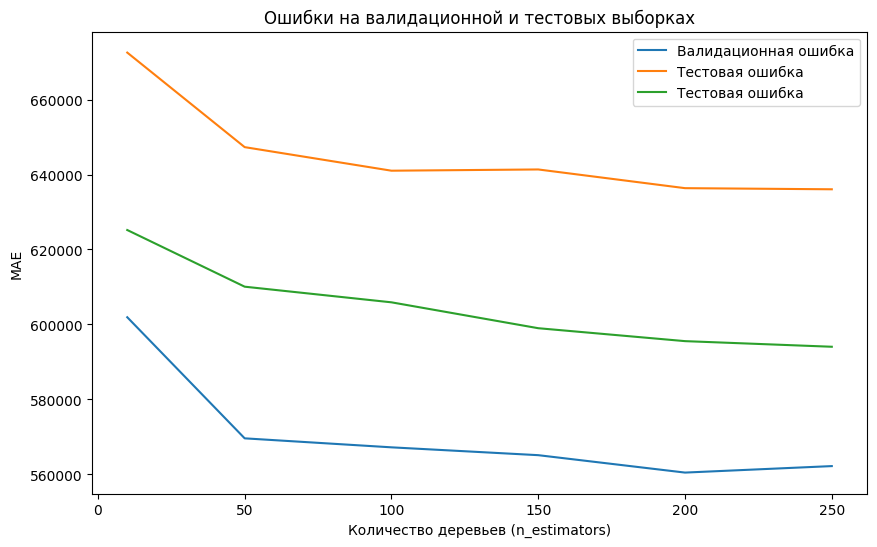

In [420]:
# Предсказания на тестовой выборке
test_custom_predictions = best_model_custom_rf.predict(X_test)
test_custom_mse = adaptive_error_func(y_test, test_custom_predictions)
print(f"{scoring_type} для случайного леса на тестовой выборке:", test_custom_mse)


# Обучаем финальную модель
final_custom_model = CustomRandomForest(**best_custom_params, random_state=42)
final_custom_model.fit(X_train_val_combined.values, y_train_val_combined.values)


# Проверка на тестовой выборке
test_val_custom_predictions = final_custom_model.predict(X_test)
test_val_custom_mse = adaptive_error_func(y_test, test_val_custom_predictions)
print(f"{scoring_type} на тестовой выборке:", test_mse)


# Оптимизация количества деревьев
estimators_range = [10, 50, 100, 150, 200, 250]
val_mses = []
test_mses = []
test_val_mses = []

for n_estimators in estimators_range:
    temp_custom_model = CustomRandomForest(n_estimators=n_estimators, random_state=42)
    temp_custom_model.fit(X_train.values, y_train.values)
    val_mses.append(adaptive_error_func(y_val, temp_custom_model.predict(X_val)))
    test_mses.append(adaptive_error_func(y_test, temp_custom_model.predict(X_test)))
    
    temp_custom_model = CustomRandomForest(n_estimators=n_estimators, random_state=42)
    temp_custom_model.fit(X_train_val_combined.values, y_train_val_combined.values)
    test_val_mses.append(adaptive_error_func(y_test, temp_custom_model.predict(X_test)))


# График метрик для валидационной и тестовой выборок по количеству деревьев
plt.figure(figsize=(10, 6))
plt.plot(estimators_range, val_mses, label="Валидационная ошибка")
plt.plot(estimators_range, test_mses, label="Тестовая ошибка")
plt.plot(estimators_range, test_val_mses, label="Тестовая ошибка")
plt.xlabel("Количество деревьев (n_estimators)")
plt.ylabel(f"{scoring_type}")
plt.title("Ошибки на валидационной и тестовых выборках")
plt.legend()
plt.show()

### Сравнение качества моделей
   - Сравнение **MAE всех моделей**: базовой, sklearn и кастомной.

In [421]:
# Создание таблицы с оценкой точности после запуска
all_model_score_tunned = pd.DataFrame({	'Model_Name': ['BaseLine', 'Random Forest', 'Custom Random Forest'], 
										f'{scoring_type}_Test_Tr+Val': [int(baseline_mse), int(test_val_mse), int(test_val_custom_mse)], 
										f'{scoring_type}_Test_Tr': [int(baseline_mse), int(test_mse), int(test_custom_mse)], 
										f'{scoring_type}_Val_Tr': [int(baseline_mse), int(val_mse), int(val_custom_mse)], 
										f'{scoring_type}_BestVal_Tr': [int(baseline_mse), int(best_val_mse), int(best_val_custom_mse)]})
all_model_score_tunned = all_model_score_tunned.sort_values(by=[f'{scoring_type}_Test_Tr'], ascending=True)
all_model_score_tunned

,Model_Name,MAE_Test_Tr+Val,MAE_Test_Tr,MAE_Val_Tr,MAE_BestVal_Tr
1,Random Forest,597316,635568,569962,565498
2,Custom Random Forest,595530,635986,567177,560274
0,BaseLine,2058590,2058590,2058590,2058590


#### При квантилях 0.05 и 0.95 (исключение выбросов)
<!-- ![image2](https://i.imgur.com/l3BY7TR.png) -->
![image6](./image6.png)

#### При квантилях 0.1 и 0.9 (исключение выбросов)
<!-- ![image1](https://i.imgur.com/mqzVamG.png) -->
![image5](./image5.png)

#### При квантилях 0.15 и 0.85 (исключение выбросов)
<!-- ![image3](https://i.imgur.com/4L6J9ND.png) -->
![image4](./image4.png)

#### При квантилях 0.20 и 0.80 (исключение выбросов)
<!-- ![image3](https://i.imgur.com/4L6J9ND.png) -->
![image4](./image7.png)

### Ручные предсказания
Предсказание цены квартиры на собственных данных

In [422]:
testDict1 = {
		'Общая площадь' : [46.2],
		'Грузовой лифт' : [1],
		'Пассажирский лифт' : [1],  
		'Залог' : [0], 
		'Этаж' : [13],  
		'Год постройки' : [2012],  
		'Этажей в доме' : [14],  
		'Площадь кухни' : [11.7], 
		'Жилая площадь' : [18.5], 
		'Количество комнат' : [1],  
		'Ремонт' : ['косметический'],
		'Тёплый пол' : [''],
		'Техника' : ['водонагреватель, кондиционер, микроволновка, плита, телевизор, утюг, холодильник'],
		'Тип дома' : ['кирпичный'],
		'Мебель' : ['кухня, спальные места, хранение одежды'],
		'Сеть' : [''],
		'Город' : ['sankt-peterburg'],
		'Балкон' : ['лоджия'],
		'Санузел' : ['совмещенный'],
		'Парковка' : ['за шлагбаумом во дворе, на улице, открытая во дворе, бесплатно для гостей'],
	}

testDict2 = {
		'Общая площадь' : [22],
		'Грузовой лифт' : [1],
		'Пассажирский лифт' : [4],  
		'Залог' : [0], 
		'Этаж' : [11],  
		'Год постройки' : [2022],  
		'Этажей в доме' : [20],  
		'Площадь кухни' : [4], 
		'Жилая площадь' : [10], 
		'Количество комнат' : [0],  
		'Ремонт' : ['дизайнерский'],
		'Тёплый пол' : [''],
		'Техника' : ['микроволновка, плита, телевизор, утюг, холодильник, стиральная машина'],
		'Тип дома' : ['монолитный'],
		'Мебель' : ['кухня, спальные места, хранение одежды'],
		'Сеть' : [''],
		'Город' : ['sankt-peterburg'],
		'Балкон' : [''],
		'Санузел' : ['совмещенный'],
		'Парковка' : ['за шлагбаумом во дворе, на улице, открытая во дворе, бесплатно для гостей'],
	}



testDict3 = {
		'Общая площадь' : [31.1],
		'Грузовой лифт' : [0],
		'Пассажирский лифт' : [0],  
		'Залог' : [0], 
		'Этаж' : [2],  
		'Год постройки' : [1960],  
		'Этажей в доме' : [5],  
		'Площадь кухни' : [6], 
		'Жилая площадь' : [16.3], 
		'Количество комнат' : [1],  
		'Ремонт' : ['косметический'],
		'Тёплый пол' : [''],
		'Техника' : ['микроволновка, плита, телевизор, утюг, холодильник, стиральная машина'],
		'Тип дома' : ['панельный'],
		'Мебель' : ['кухня, спальные места, хранение одежды'],
		'Сеть' : [''],
		'Город' : ['sankt-peterburg'],
		'Балкон' : ['балкон'],
		'Санузел' : ['совмещенный'],
		'Парковка' : ['на улице, открытая во дворе, бесплатно для гостей'],
	}




def customPredict(dataType=custom_data_debug, testDict=testDict1, filePath='../../supervised-GameTrue/src/testPrediction/testData.xlsx', sheetName='Summarize', debug=custom_value_debug, formatType='str'):
	intDataList2 = ["Количество комнат", "Пассажирский лифт", "Грузовой лифт", "Этаж", "Год постройки", "Этажей в доме", "Залог"]

	if dataType == 'Manual':
		testData = pd.DataFrame(testDict)
		testData = one_hot_encode_multilabel(testData, onehotVariables, True)
	elif dataType == 'Excel':
		# Load the dataset
		testData = pd.read_excel(filePath, sheet_name=sheetName)



	testData = testData.reindex(columns=X_test.columns, fill_value=0)
	testData = pd_to_int(testData, intDataList2)


	testing_test_val_predictions = np.array([f"{x:,}".replace(",", " ") for x in final_model.predict(testData.values).astype(int)]) if formatType == 'str' else final_model.predict(testData.values).astype(int)

	if debug:
		print(testing_test_val_predictions)
	# print(testing_test_val_predictions2)

	return (testData, testing_test_val_predictions)

In [423]:
testData, prediction = customPredict(testDict=testDict3)

names = pd.DataFrame({
	'Хозяин':
	  ['Соня', 'Соня', 'Соня', 'Соня', 'Соня', 'Соня', 'Ваня']
	})
citiNames = extract_category_column(testData, ['Город'])
predictedPrice = pd.DataFrame({
	'Predicted price': prediction
	})

pd.concat([names, testData['Общая площадь'], citiNames, predictedPrice], axis=1)

,Хозяин,Общая площадь,Город,Predicted price
0,Соня,46.2,sankt-peterburg,9 022 799
1,Соня,46.2,belgorodskaya_oblast,5 387 814
2,Соня,46.2,krasnodarskiy_kray,5 470 934
3,Соня,46.2,krasnoyarskiy_kray,5 704 904
4,Соня,46.2,moskva,12 120 199
5,Соня,46.2,primorskiy_kray,5 808 999
6,Ваня,22.0,sankt-peterburg,4 729 184


In [424]:
# row_1 = testData2.iloc[0:1]
# row_1_aligned, df2_aligned = row_1.align(testData, axis=1, copy=False)
# diff = df2_aligned != row_1_aligned.iloc[0]

# # Отфильтруем строки, где есть хотя бы одно отличие
# diff_rows = testData[diff.any(axis=1)]

# print("Строки, которые отличаются от первой строки df1:")
# print(diff_rows)